In [138]:
#ahmadreza baqerzadeh homaee

In [139]:
import torch as tc 
from torch import nn,optim 
from torchmetrics import Accuracy 
from torch.utils.data import DataLoader,TensorDataset 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm 
import csv
from torch.utils.data import random_split

In [140]:
!uncompress '/home/ahmadreza/git/rep5/dataset/shuttle.trn.Z'

gzip: /home/ahmadreza/git/rep5/dataset/shuttle.trn.Z: No such file or directory


In [141]:
def read_file(file):
  with open(file, 'rb') as fh:
      decompressed_data = fh.read()
  list_data = decompressed_data.decode('utf-8').splitlines()
  row=[]
  for i in list_data:
    col=[]
    for j in i.split():
        col.append(float(j))
    row.append(col)
  pd.DataFrame(row).to_csv('/home/ahmadreza/git/rep5/dataset/train.csv')

read_file('/home/ahmadreza/git/rep5/dataset/shuttle.trn')
train=pd.read_csv('/home/ahmadreza/git/rep5/dataset/train.csv')
test=pd.read_csv('/home/ahmadreza/git/rep5/dataset/shuttledata_test.csv')

In [142]:
col=test.columns.values
change=[]
for i in col:
  change.append(float(i))

xtest=tc.cat((tc.FloatTensor(change).unsqueeze(dim=0),tc.FloatTensor(test.values)),dim=0)

In [143]:
train.drop('Unnamed: 0',axis=1,inplace=True)

In [144]:
x=train.drop('9',axis=1)
y=train['9']-1

In [145]:
xtrain,xvalid,ytrain,yvalid=train_test_split(x,y,train_size=0.7,random_state=42)

In [146]:
xtrain=tc.FloatTensor(xtrain.values)
ytrain=tc.LongTensor(ytrain.values)
xvalid=tc.FloatTensor(xvalid.values)
yvalid=tc.LongTensor(yvalid.values)

In [147]:
mean=xtrain.mean(dim=0)
std=xtrain.std(dim=0)

In [148]:
xtrain=(xtrain-mean)/std 
xvalid=(xvalid-mean)/std 
xtest=(xtest-mean)/std

In [149]:
train_dataset=TensorDataset(xtrain,ytrain)
valid_dataset=TensorDataset(xvalid,yvalid)

In [150]:
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=256,shuffle=False)

In [151]:
device='cuda' if tc.cuda.is_available() else 'cpu'

In [152]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7))

In [153]:
model=model.to(device)

In [154]:
loss_func=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1)

In [155]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [156]:
def train_one_epoch(model,train_loader,loss_func,optimizer,epoch):
  model.train()
  train_loss=AverageMeter()
  train_acc=Accuracy(task='multiclass',num_classes=7).to(device)
  with tqdm(train_loader,unit='batch') as tepoch:
    for x,y in tepoch:
        if epoch is not None:
          tepoch.set_description(f'Epoch{epoch}')
        x=x.to(device)
        y=y.to(device)
        yp=model(x)
        loss=loss_func(yp.squeeze(),y)
        train_loss.update(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_acc(yp,y.int())
        tepoch.set_postfix(loss=train_loss.avg,
                      accuracy=100*train_acc.compute().item())


  return model,train_loss.avg,train_acc.compute().item()

def validation(model,valid_loader,loss_func):

  valid_loss=AverageMeter()
  valid_acc=Accuracy(task='multiclass',num_classes=7).to(device)

  for j,(x,y) in enumerate(valid_loader):
    x=x.to(device)
    y=y.to(device)
    yp=model(x)
    loss=loss_func(yp.squeeze(),y)
    valid_loss.update(loss.item())
    valid_acc(yp.squeeze(),y)

  print(f'valid loss={valid_loss.avg:.4},accuracy={valid_acc.compute():.4}')
  print()

  return valid_loss.avg,valid_acc.compute().item()

In [157]:
xbatch,ybatch=next(iter(train_loader))
yp=model(xbatch.to(device))
loss_func(yp,ybatch.to(device))
  

tensor(2.1532, device='cuda:0', grad_fn=<NllLossBackward0>)

In [158]:
mini_batch,_=random_split(train_dataset,(100,len(train_dataset)-100))
mini_loader=DataLoader(mini_batch,batch_size=20,shuffle=True)

In [159]:
for i in range(10):
  model,_,_=train_one_epoch(model,mini_loader,loss_func,optimizer,i)


Epoch9: 100%|██████████| 5/5 [00:00<00:00, 211.47batch/s, accuracy=79, loss=0.506]


In [160]:
for lr in [0.1,0.01,0.001,0.0001]:
  model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7)).to(device)
  optimizer=optim.SGD(model.parameters(),lr=lr)
  print(f'LR={lr}')
  model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,1)

LR=0.1


Epoch1: 100%|██████████| 238/238 [00:01<00:00, 199.17batch/s, accuracy=91.1, loss=0.334]


LR=0.01


Epoch1: 100%|██████████| 238/238 [00:01<00:00, 193.90batch/s, accuracy=62.7, loss=1.4] 


LR=0.001


Epoch1: 100%|██████████| 238/238 [00:01<00:00, 211.30batch/s, accuracy=70.4, loss=1.78]


LR=0.0001


Epoch1: 100%|██████████| 238/238 [00:01<00:00, 214.44batch/s, accuracy=15.5, loss=1.94]


In [161]:
lr_n=[0.1,0.15,0.2,0.25]
wd_n=[0,1e-4,1e-5,1e-6,1e-7]
result=[]
for lr in lr_n:
  lr_result=[]
  for wd in wd_n:
    model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7)).to(device)
    optimizer=optim.SGD(model.parameters(),lr=lr)
    N=5
    print(f'LR={lr},weight_decay={wd}')

    for i in range(N):

      model,train_loss,_=train_one_epoch(model,train_loader,loss_func,optimizer,i)

      if i==0:
        e1=train_loss
      if i==N-1:
        e2=train_loss

    lr_result.append(f'{e1:.4}-{e2:.4}={e1-e2:.4}')
    print()
  result.append(lr_result)

LR=0.1,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 210.68batch/s, accuracy=99.4, loss=0.044] 



LR=0.1,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 212.92batch/s, accuracy=99.4, loss=0.0463]



LR=0.1,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 194.94batch/s, accuracy=99.4, loss=0.0456]



LR=0.1,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 173.45batch/s, accuracy=99.4, loss=0.0371]



LR=0.1,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 206.22batch/s, accuracy=99.4, loss=0.048] 



LR=0.15,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 190.51batch/s, accuracy=99.4, loss=0.0321]



LR=0.15,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 209.77batch/s, accuracy=99.3, loss=0.0358]



LR=0.15,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:00<00:00, 250.87batch/s, accuracy=99.4, loss=0.0352]



LR=0.15,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:00<00:00, 256.94batch/s, accuracy=99.4, loss=0.0345]



LR=0.15,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:00<00:00, 260.83batch/s, accuracy=99.4, loss=0.0323]



LR=0.2,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 195.22batch/s, accuracy=99.5, loss=0.0312]



LR=0.2,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 195.91batch/s, accuracy=99.5, loss=0.0281]



LR=0.2,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 205.38batch/s, accuracy=99.5, loss=0.0309]



LR=0.2,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 198.78batch/s, accuracy=99.5, loss=0.0272]



LR=0.2,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 201.75batch/s, accuracy=99.5, loss=0.0293]



LR=0.25,weight_decay=0


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 167.45batch/s, accuracy=99.4, loss=0.0277]



LR=0.25,weight_decay=0.0001


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 200.02batch/s, accuracy=99.4, loss=0.0288]



LR=0.25,weight_decay=1e-05


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 188.75batch/s, accuracy=99.5, loss=0.0271]



LR=0.25,weight_decay=1e-06


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 197.18batch/s, accuracy=99.4, loss=0.0283]



LR=0.25,weight_decay=1e-07


Epoch4: 100%|██████████| 238/238 [00:01<00:00, 187.42batch/s, accuracy=99.5, loss=0.0288]

In [162]:
pd.DataFrame(result,index=lr_n,columns=wd_n)

,0.000000e+00,1.000000e-04,1.000000e-05,1.000000e-06,1.000000e-07
0.10,0.3571-0.04395=0.3132,0.3645-0.04629=0.3182,0.3841-0.04558=0.3385,0.3681-0.03714=0.3309,0.3427-0.048=0.2947
0.15,0.271-0.03207=0.2389,0.2763-0.0358=0.2405,0.2944-0.03516=0.2592,0.2901-0.0345=0.2556,0.2516-0.03229=0.2193
0.20,0.2578-0.03123=0.2266,0.2002-0.02813=0.1721,0.2667-0.03091=0.2358,0.2182-0.02718=0.191,0.2286-0.02934=0.1993
0.25,0.2266-0.02773=0.1988,0.2395-0.02883=0.2107,0.217-0.02713=0.1899,0.2156-0.02833=0.1873,0.224-0.02878=0.1952


In [163]:
model=nn.Sequential(nn.Linear(xtrain.shape[1],64),
                    nn.ReLU(),nn.Linear(64,32),
                    nn.ReLU(),nn.Linear(32,16),
                    nn.ReLU(),nn.Linear(16,7),nn.Softmax())
optimizer=optim.SGD(model.parameters(),lr=0.1,weight_decay=1e-4)

In [164]:
model=model.to(device)

In [165]:
N=25
acc_train_hist,loss_train_hist=[],[]
acc_valid_hist,loss_valid_hist=[],[]

for i in range(N):

  model,train_loss,train_acc=train_one_epoch(model,train_loader,loss_func,optimizer,i)
  valid_loss,valid_acc=validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

Epoch0:   0%|          | 0/238 [00:00<?, ?batch/s]/home/ahmadreza/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch0: 100%|██████████| 238/238 [00:01<00:00, 200.73batch/s, accuracy=73.8, loss=1.5] 


valid loss=1.352,accuracy=0.7858



Epoch1: 100%|██████████| 238/238 [00:01<00:00, 200.82batch/s, accuracy=82.5, loss=1.33]


valid loss=1.298,accuracy=0.8439



Epoch2: 100%|██████████| 238/238 [00:01<00:00, 202.85batch/s, accuracy=94.2, loss=1.26]


valid loss=1.212,accuracy=0.9753



Epoch3: 100%|██████████| 238/238 [00:01<00:00, 195.91batch/s, accuracy=97.9, loss=1.2] 


valid loss=1.194,accuracy=0.9812



Epoch4: 100%|██████████| 238/238 [00:01<00:00, 200.01batch/s, accuracy=98.4, loss=1.19]


valid loss=1.188,accuracy=0.9843



Epoch5: 100%|██████████| 238/238 [00:01<00:00, 199.02batch/s, accuracy=98.5, loss=1.19]


valid loss=1.185,accuracy=0.9867



Epoch6: 100%|██████████| 238/238 [00:01<00:00, 199.39batch/s, accuracy=98.7, loss=1.18]


valid loss=1.182,accuracy=0.9868



Epoch7: 100%|██████████| 238/238 [00:01<00:00, 199.26batch/s, accuracy=98.9, loss=1.18]


valid loss=1.178,accuracy=0.9906



Epoch8: 100%|██████████| 238/238 [00:01<00:00, 208.35batch/s, accuracy=99.3, loss=1.18]


valid loss=1.177,accuracy=0.9932



Epoch9: 100%|██████████| 238/238 [00:01<00:00, 208.41batch/s, accuracy=99.4, loss=1.18]


valid loss=1.174,accuracy=0.9955



Epoch10: 100%|██████████| 238/238 [00:01<00:00, 186.21batch/s, accuracy=99.5, loss=1.17]


valid loss=1.173,accuracy=0.9951



Epoch11: 100%|██████████| 238/238 [00:01<00:00, 174.67batch/s, accuracy=99.5, loss=1.17]


valid loss=1.173,accuracy=0.9953



Epoch12: 100%|██████████| 238/238 [00:01<00:00, 184.48batch/s, accuracy=99.5, loss=1.17]


valid loss=1.173,accuracy=0.9955



Epoch13: 100%|██████████| 238/238 [00:01<00:00, 212.44batch/s, accuracy=99.5, loss=1.17]


valid loss=1.172,accuracy=0.9954



Epoch14: 100%|██████████| 238/238 [00:01<00:00, 201.61batch/s, accuracy=99.5, loss=1.17]


valid loss=1.172,accuracy=0.9953



Epoch15: 100%|██████████| 238/238 [00:01<00:00, 201.65batch/s, accuracy=99.5, loss=1.17]


valid loss=1.172,accuracy=0.9953



Epoch16: 100%|██████████| 238/238 [00:01<00:00, 209.18batch/s, accuracy=99.5, loss=1.17]


valid loss=1.172,accuracy=0.9953



Epoch17: 100%|██████████| 238/238 [00:01<00:00, 196.50batch/s, accuracy=99.5, loss=1.17]


valid loss=1.172,accuracy=0.9953



Epoch18: 100%|██████████| 238/238 [00:01<00:00, 200.81batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9954



Epoch19: 100%|██████████| 238/238 [00:01<00:00, 187.25batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9954



Epoch20: 100%|██████████| 238/238 [00:01<00:00, 208.92batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9955



Epoch21: 100%|██████████| 238/238 [00:01<00:00, 190.96batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9956



Epoch22: 100%|██████████| 238/238 [00:01<00:00, 182.39batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9956



Epoch23: 100%|██████████| 238/238 [00:01<00:00, 207.03batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9955



Epoch24: 100%|██████████| 238/238 [00:01<00:00, 205.75batch/s, accuracy=99.5, loss=1.17]


valid loss=1.171,accuracy=0.9956



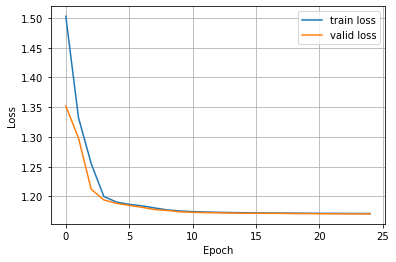

In [166]:
plt.plot(range(N),loss_train_hist,label='train loss')
plt.plot(range(N),loss_valid_hist,label='valid loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [167]:
#good fit

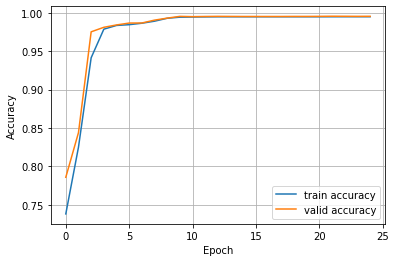

In [168]:
plt.plot(range(N),acc_train_hist,label='train accuracy')
plt.plot(range(N),acc_valid_hist,label='valid accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [169]:
tc.save(model,'model.pth')

In [170]:
ypred=model(xtest.to(device)).cpu()

In [171]:
ypred_save=[]
for i in ypred:
  b=max(i)
  for j in range(len(i)):
    if i[j]==b:
      ypred_save.append(j)

In [172]:
df_prediction=pd.DataFrame(ypred_save,columns=['pred'])+1

In [173]:
df_prediction.to_csv('/home/ahmadreza/git/rep5/dataset/prediction.csv')